In [1]:
# requirements.txt
#
# git+https://github.com/glue-viz/glue-jupyter
# git+https://github.com/glue-viz/glue-astronomy
# regions
# specutils
# photutils
# astropy
# numpy
# matplotlib

from specutils import Spectrum1D
from regions import read_ds9, CircleSkyRegion
from photutils import SkyCircularAperture, aperture_photometry
from astropy.io import fits
from astropy import wcs
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

### Read in files

In [2]:
filename = '/user/pogle/q3dsim/NRS00001-G-F100LP-G140H-01_1_1020_JW1_IPS_20200114T120000.000_20200115T120000.000/NRS00001-G-F100LP-G140H-01_1_SE_2020-01-14T12h15m00_s3d.fits'

import glue_jupyter as gj
app = gj.jglue()
app.load_data(filename)
image_viewer = app.imshow(data='NRS00001-G-F100LP-G140H-01_1_SE_2020-01-14T12h15m00_s3d[SCI]')

/Users/jdavies/miniconda3/envs/notebook/lib/python3.8/site-packages/glue/external/echo/__init__.py:3: UserWarning: glue.external.echo is deprecated, import from echo directly instead
  warnings.warn('glue.external.echo is deprecated, import from echo directly instead')
/Users/jdavies/miniconda3/envs/notebook/lib/python3.8/site-packages/glue/core/data_factories/fits.py:152: UserWarning: Dropping column 'ASDF_METADATA' since it is not 1-dimensional
  warnings.warn("Dropping column '{0}' since it is not 1-dimensional".format(column_name))


Html(children=[Toolbar(children=[ToolbarItems(children=[BasicJupyterToolbar(children=[Tooltip(bottom=True, chi…

In [3]:
data = app.data_collection[0]
pix_region = data.get_selection_definition(format='astropy-regions')
pix_region

<CirclePixelRegion(PixCoord(x=25.212804794311523, y=24.68719482421875), radius=8.381162643432617)>

In [4]:
with fits.open(filename, memmap=False) as hdulist:
    sci = hdulist["SCI"].data
    err = hdulist["ERR"].data
    w = wcs.WCS(hdulist[1].header)
spec1d = Spectrum1D.read(filename)

/Users/jdavies/miniconda3/envs/notebook/lib/python3.8/site-packages/asdf/asdf.py:189: UserWarning: File '/user/pogle/q3dsim/NRS00001-G-F100LP-G140H-01_1_1020_JW1_IPS_20200114T120000.000_20200115T120000.000/NRS00001-G-F100LP-G140H-01_1_SE_2020-01-14T12h15m00_s3d.fits' was created with extension 'jwst.transforms.jwextension.JWSTExtension', which is not currently installed (from package jwst-0.14.3a1.dev86+g38403faa)
  warnings.warn(fmt_msg)


### Create a `SkyCircularAperture`

In [5]:
# Read in a ds9 region file
# region = read_ds9('/user/pogle/q3dsim/NRS00001-G-F100LP-G140H-01_1_1020_JW1_IPS_20200114T120000.000_20200115T120000.000/q3d_circle.reg')[0]
# aperture = SkyCircularAperture(region.center, region.radius)

# or

# Use region selection from glue-jupyter viewer above to make an aperture
pixel_scale = np.sqrt(np.abs(np.prod(w.celestial.wcs.cdelt)))
center = w.celestial.pixel_to_world(pix_region.center.x, pix_region.center.y)
radius = pix_region.radius * pixel_scale * 3600 * u.arcsec
# Convert CirclePixelRegion to CircleSkyRegion
region = CircleSkyRegion(center, radius)
aperture = SkyCircularAperture(region.center, region.radius)
aperture

<SkyCircularAperture(<SkyCoord (ICRS): (ra, dec) in deg
    (156.1778049, -45.6869575)>, r=0.8381162768321666 arcsec)>

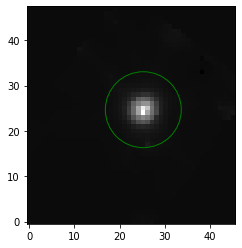

In [6]:
pixel_region = region.to_pixel(w.celestial)
ax = plt.subplots()[1]
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(np.mean(sci, axis=0), cmap='gray', origin='lower', norm=norm)
pixel_region.plot(axes=ax)

### Now for each spatial slice, compute the sum in the aperture

In [7]:
sums = []
errs = []
reference_wavelength = spec1d.spectral_axis[0]

for wavelength, scislice, error in zip(spec1d.spectral_axis, sci, err):
    aperture_radius = aperture.r * wavelength / reference_wavelength
    aperture_cone = SkyCircularAperture(region.center, aperture_radius)
    phot_table = aperture_photometry(scislice, aperture_cone, wcs=w.celestial,
                                     method="exact", error=error)
    sums.append(phot_table["aperture_sum"][0])
    errs.append(phot_table["aperture_sum_err"][0])

flux = np.array(sums) * spec1d.flux.unit
uncertainty = StdDevUncertainty(np.array(errs))

In [8]:
extracted_spec = Spectrum1D(flux=flux, spectral_axis=spec1d.spectral_axis,
                            uncertainty=uncertainty)

[]

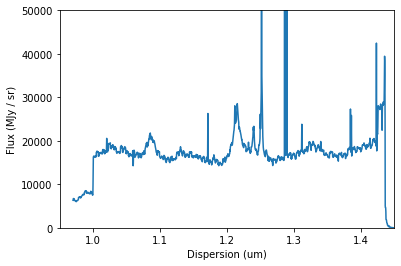

In [9]:
ax = plt.subplots()[1]
ax.plot(extracted_spec.spectral_axis, extracted_spec.flux)
ax.set_xlim(0.95,1.45)
ax.set_ylim(0,50000)
ax.set_xlabel(f"Dispersion ({extracted_spec.spectral_axis.unit.to_string()})")
ax.set_ylabel(f"Flux ({extracted_spec.flux.unit.to_string()})")
plt.plot()